# 25-D Correlated Normal

## Setup

First, let's set up some environmental dependencies. These just make the numerics easier and adjust some of the plotting defaults to make things more legible.

In [1]:
# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
from numpy import linalg

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt

# seed the random number generator
rstate = np.random.default_rng(21)

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
import dynesty

`dynesty` supports three tiers of sampling techniques: uniform sampling for low dimensional problems, random walks for low-to-moderate dimensional problems, and slice sampling for high-dimensional problems (with or without the use of gradients). Here we will quickly demonstrate that slice sampling is able to cope with high-dimensional problems using a 25-D correlated multivariate normal distribution.

In [4]:
ndim = 25  # number of dimensions
C = np.identity(ndim)  # set covariance to identity matrix
C[C==0] = 0.4  # set off-diagonal terms (strongly correlated)
Cinv = linalg.inv(C)  # precision matrix
lnorm = -0.5 * (np.log(2 * np.pi) * ndim + np.log(linalg.det(C)))  # ln(normalization)

# 3-D correlated multivariate normal log-likelihood
def loglikelihood(x):
    """Multivariate normal log-likelihood."""
    return -0.5 * np.dot(x, np.dot(Cinv, x)) + lnorm

# prior transform
def prior_transform(u):
    """Transforms our unit cube samples `u` to a flat prior between -5. and 5. in each variable."""
    return 5. * (2. * u - 1.)

# gradient of log-likelihood *with respect to u*
def gradient(x):
    """Multivariate normal log-likelihood gradient."""
    dlnl_dv = -np.dot(Cinv, x)  # standard gradient
    jac = np.diag(np.full_like(x, 10.))  # Jacobian
    return np.dot(jac, dlnl_dv)  # transformed gradient

# ln(evidence)
lnz_truth = -ndim * np.log(10. * 0.999999426697)
print(lnz_truth)

-57.56461299227203


Since we know this is a unimodal case, we'll initialize our sampler in the `'single'` bounding mode. 

In [5]:
# multivariate slice sampling ('slice')
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim, 
                                nlive=500, bound='single', 
                                sample='slice', slices=5, rstate=rstate)
sampler.run_nested(dlogz=0.01)
res = sampler.results

20704it [03:23, 101.89it/s, +500 | bound: 201 | nc: 1 | ncall: 12389914 | eff(%):  0.171 | loglstar:   -inf < -20.350 <    inf | logz: -57.113 +/-  0.233 | dlogz:  0.000 >  0.010]


In [6]:
# random slice sampling ('rslice')
sampler = dynesty.NestedSampler(loglikelihood, prior_transform, ndim,
                                nlive=500, bound='single', 
                                sample='rslice', slices=25,
                                rstate=rstate)
sampler.run_nested(dlogz=0.01)
res2 = sampler.results

20678it [00:50, 409.32it/s, +500 | bound: 203 | nc: 1 | ncall: 2490333 | eff(%):  0.851 | loglstar:   -inf < -20.779 <    inf | logz: -57.490 +/-  0.233 | dlogz:  0.000 >  0.010]


Now let's see how we do.

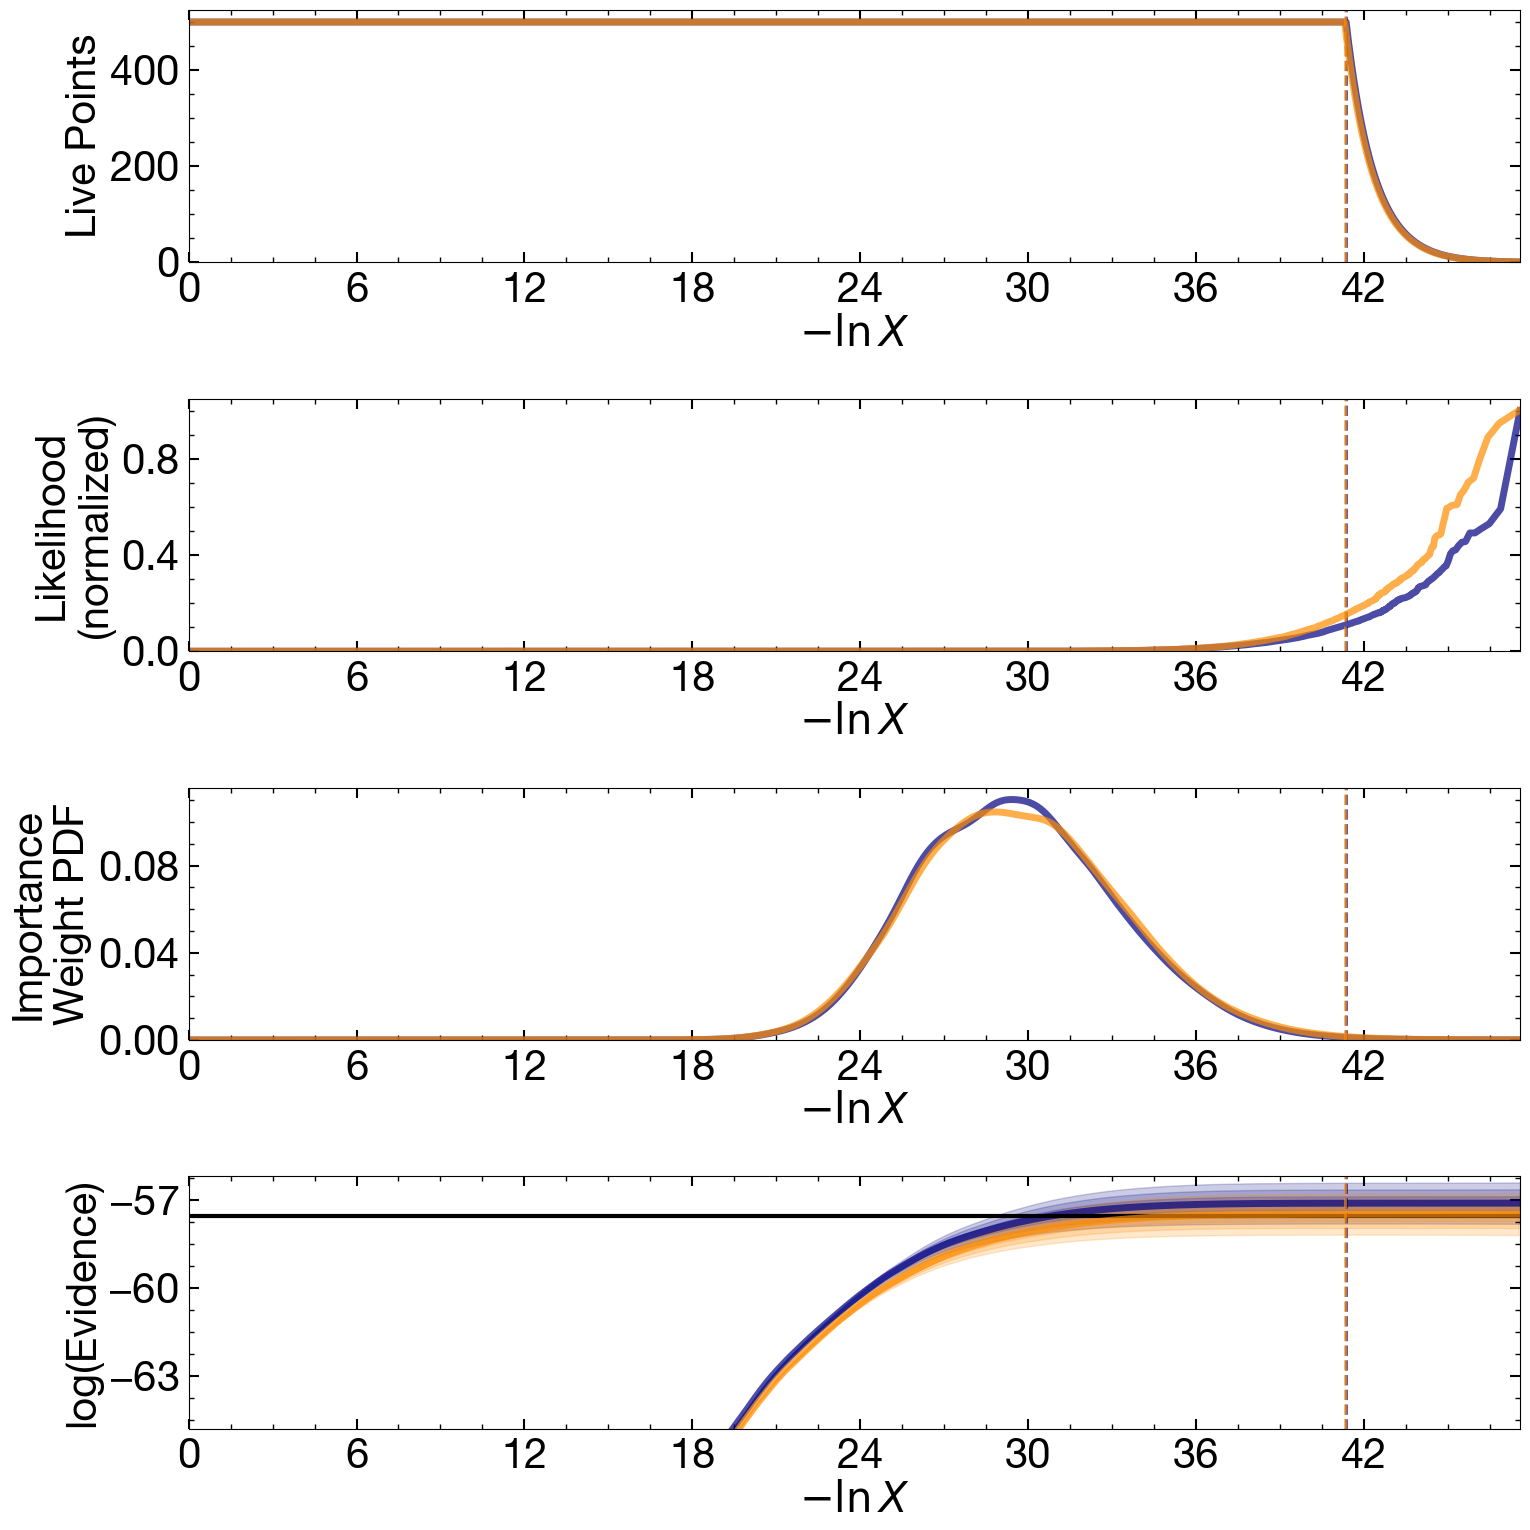

In [8]:
from dynesty import plotting as dyplot

fig, axes = dyplot.runplot(res, color='navy', logplot=True,
                           lnz_truth=lnz_truth, truth_color='black')
fig, axes = dyplot.runplot(res2, color='darkorange', logplot=True, fig=(fig, axes))
fig.tight_layout()

In [9]:
from dynesty import utils as dyfunc

print('Mean:')
print('slice:', dyfunc.mean_and_cov(res.samples, 
                                    np.exp(res.logwt-res.logz[-1]))[0])
print('rslice:', dyfunc.mean_and_cov(res2.samples, 
                                     np.exp(res2.logwt-res2.logz[-1]))[0])


print('\nVariance:')
print('slice:', np.diagonal(dyfunc.mean_and_cov(res.samples, 
                                                np.exp(res.logwt-res.logz[-1]))[1]))
print('rslice:', np.diagonal(dyfunc.mean_and_cov(res2.samples, 
                                                 np.exp(res2.logwt-res2.logz[-1]))[1]))

Mean:
slice: [-0.00398794 -0.00652683 -0.01661564 -0.01608146 -0.02067502 -0.00946109
  0.01311866 -0.00195096 -0.00112127 -0.0092188  -0.01032398 -0.00451505
 -0.02172574 -0.01277736 -0.01089023 -0.01831242 -0.00403352 -0.02259593
 -0.01702902 -0.02388776 -0.00518302  0.01797981 -0.00842151 -0.01028236
 -0.00769711]
rslice: [ 0.00601609 -0.01385759 -0.00193828  0.00044803 -0.01732251 -0.01499673
 -0.00498437  0.00434763 -0.00584813 -0.02430046  0.01266894  0.00783362
 -0.01227354 -0.01942864  0.02219051 -0.0021391   0.00653592  0.00634409
  0.01349779  0.02902501  0.00339456 -0.00135797 -0.01550673 -0.00903943
 -0.00559825]

Variance:
slice: [0.98927927 0.98825981 0.9922869  0.95349522 0.96963369 0.99000528
 0.94790327 0.96715723 0.96603736 0.96088411 0.97308325 0.94101271
 0.95311748 0.9657489  0.95529361 1.00861731 0.97175948 0.98768024
 0.96935961 0.98675564 0.95337208 0.96154794 0.98415329 0.97842147
 0.9554545 ]
rslice: [0.99208636 0.97496314 0.98005755 0.99888937 0.97355043 0.99